In [62]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from numpy.linalg import inv, det
from scipy.optimize import minimize

In [63]:
# Initial sensor data (X_sample and y_sample)
xtrain = np.array([[0.1, 0.05], [-0.9, 0.3], [0.2, 0.4], [0.8, -0.3],
                     [-0.6, 0.3], [0.3, -0.2], [0.5, -0.84], [-0.5, 0.85],
                     [-0.01, -0.76], [-0.9, -0.9]])  # Initial sensor locations
xtrain = np.append(xtrain,[[-0.9,-0.4],[-0.9,-0.5],[0.8,-1.0],[-1.0,0.5]],axis=0) # Updated sensor readings after 1st call
xtrain = np.append(xtrain,[[0.81,-0.85],[0.82,-0.85],[0.90,-0.75],[0.95,-0.80]],axis=0) # Updated sensor readings after 2nd call
xtrain = np.append(xtrain,[[0.99,0.32],[0.99,0.35],[0.99,0.33],[0.99,0.34]],axis=0) # Updated sensor readings after 3rd call


ytrain = np.array([3.39, 3.20, 3.40, 3.68, 2.96, 2.99, 3.94, 2.80, 3.34, 3.91])  # Initial sensor readings
ytrain = np.append(ytrain,[3.10,3.05,4.12,3.08])# Updated sensor readings after 1st call
ytrain = np.append(ytrain,[4.5055,4.5180,4.2525,4.51375])# Updated sensor readings after 2nd call
ytrain = np.append(ytrain,[3.83,3.69,3.78,3.74])# Updated sensor readings after 3nd call

In [64]:
mean_func = lambda x: np.zeros((x.shape[0]))

# Define the Squared Exponential kernel for 2D inputs
# def sq_exp_kernel(X1, X2, l=0.69, tau=2.89):
#     """Squared Exponential kernel for 2D inputs."""
#     # Calculating euclidean distance
#     sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
#     return   (tau**2) * np.exp(-0.5 * sqdist / l**2)

def sq_exp_kernel(X1, X2, l=0.44, tau=2.69):
    """Squared Exponential kernel for 2D inputs."""
    # Calculating euclidean distance
    sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return   (tau**2) * np.exp(-0.5 * sqdist / l**2)

In [65]:
def gpr(xtrain: np.ndarray,
        ytrain: np.ndarray,
        xpred: np.ndarray,
        noise_var: np.ndarray,
        mean_func: Callable[[np.ndarray], np.ndarray]):

    cov = sq_exp_kernel(xtrain, xtrain)

    # pseudoinverse
    invcov = np.linalg.pinv(cov + np.diag(noise_var))

    vec_pred = sq_exp_kernel(xpred, xtrain)
    pred_mean = mean_func(xpred) + np.dot(vec_pred, np.dot(invcov, ytrain - mean_func(xtrain)))

    cov_predict_pre = sq_exp_kernel(xpred, xpred)
    cov_predict_up = np.dot(vec_pred, np.dot(invcov, vec_pred.T))
    pred_cov = cov_predict_pre - cov_predict_up

    # Sqrt of the diagnols of the covariance matrix gives the standard deviation
    pred_sigma = np.sqrt(np.diag(pred_cov))

    return pred_mean, pred_sigma

In [66]:
# Make predictions
xtest = np.array([[-0.9, -0.9], [0.0, 0.0], [0.75, -0.5], [-0.5, 0.5], [-0.8, -0.2], [0.1, 0.05], [-0.01, -0.76], [0.81,-0.85],[0.99,0.32],[0.68, 0.13],[0.77, 0.06]])
noise_cov=1e-5
mean, sigma = gpr(xtrain=xtrain, ytrain=ytrain, xpred=xtest, noise_var=noise_cov * np.ones((xtrain.shape[0])), mean_func=mean_func)
print("Predicted mean:", mean)
print("Predicted sigma (uncertainty):", sigma)


Predicted mean: [3.90998935 3.20870568 3.38447667 2.91471216 3.38370063 3.38999071
 3.33999426 4.5044047  3.82865934 4.87457714 5.00308643]
Predicted sigma (uncertainty): [0.00316227 0.41739957 0.27795582 0.60827256 0.54331399 0.00316226
 0.00316227 0.00285389 0.0027129  1.06283464 0.75727419]


In [67]:
# Log Marginal Likelihood function
def log_likelihood(params, X_train, y_train, noise):
    length_scale, variance = params

    # Computing the kernel matrix for train data
    K = sq_exp_kernel(X_train, X_train, length_scale, variance) + noise * np.eye(len(X_train))

    # Compute the inverse of the kernel matrix
    K_inv = inv(K)

    # Computing the log marginal likelihood
    term1 = -0.5 * np.dot(y_train.T, np.dot(K_inv, y_train))
    term2 = -0.5 * np.log(det(K))
    term3 = -0.5 * len(y_train) * np.log(2 * np.pi)

    return -(term1 + term2 + term3)

# Optimize hyperparameters
def opt_params(X_train, y_train, initial_params, noise=1e-5):
    # Minimize the negative log marginal likelihood
    res = minimize(log_likelihood, initial_params, args=(X_train, y_train, noise),
                   bounds=((1e-2, 1e1), (1e-2, 1e1)), method='L-BFGS-B')

    return res.x

# Initial hyperparameters: [length_scale, variance]
initial_params = [1, 1]

# Calling the function to optimize the parameters
optimal_params = opt_params(xtrain, ytrain, initial_params)

In [68]:
print("Optimized hyperparameters:")
print("Length scale:", optimal_params[0])
print("tau:", optimal_params[1])

Optimized hyperparameters:
Length scale: 0.4469416378554061
tau: 2.691273525113237


In [69]:
# Defining EI calculation
def expected_improvement(X, X_sample, y_sample, mu, sigma):
    mu_sample_opt = np.max(y_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt
        Z = imp / sigma
        ei = imp
        ei[sigma == 0.0] = 0.0

    return ei

#Create test points grid (possible locations to sample from)
x = np.arange(-1, 1, 0.1)
y = np.arange(-1, 1, 0.1)
X_grid = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
print(X_grid.shape)

# ### For 2nd step, we can exploit at the area under the region [0.70,1.00]*[-1.00*-0.7]
# x = np.arange(0.7, 1.00, 0.01)
# y = np.arange(-1, -0.7, 0.01)
# X_grid = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
# print(X_grid.shape)

# ### For 3rd step, we can exploit at the area under the region [0.6,1.0]*[0,0.60]
# x = np.arange(0.6, 1.0, 0.01)
# y = np.arange(0, 0.60, 0.01)
# X_grid = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
# print(X_grid.shape)

# ### For final prediction, we can exploit at the area under the region [0.6,1.0]*[0,0.60]
# Create test points grid (possible locations to sample from)
# x = np.arange(0, 1, 0.01)
# y = np.arange(0, 1, 0.01)
# X_grid = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
# print(X_grid.shape)

# Calculate Expected Improvement for all test points
mu, sigma = gpr(xtrain=xtrain, ytrain=ytrain, xpred=X_grid, noise_var=noise_cov * np.ones((xtrain.shape[0])), mean_func=mean_func)
ei = expected_improvement(X_grid, xtrain, ytrain, mu, sigma)
print(ei.shape)
# Select the top 4 points with the highest EI values
idx_top_4 = np.argsort(ei)[-4:]
X_next_4 = X_grid[idx_top_4]
mu_4, sigma_4 = gpr(xtrain=xtrain, ytrain=ytrain, xpred=X_next_4, noise_var=noise_cov * np.ones((xtrain.shape[0])), mean_func=mean_func)
print("mu_4: ",mu_4)
print("sigma_4: ",sigma_4)

# Display the selected points based on EI
print("Next 4 sensor locations based on Maximum Expected Improvement:")
print(X_next_4)

print("##########")

# Select the top 4 points with the highest predicted mean (mu)
idx_top_4 = np.argsort(mu)[-4:]  # Indices of the top 12 predicted means
X_next_4 = X_grid[idx_top_4]
mu_4, sigma_4 = gpr(xtrain=xtrain, ytrain=ytrain, xpred=X_next_4, noise_var=noise_cov * np.ones((xtrain.shape[0])), mean_func=mean_func)
print("mu_4: ",mu_4)
print("sigma_4: ",sigma_4)

# Display the selected points for Maximum Exploitation
print("Next 4 sensor locations based on Maximum Exploitation (highest predicted mean):")
print(X_next_4)

print("###########")

# Select the top 12 points with the highest uncertainty (sigma)
idx_top_4 = np.argsort(sigma)[-4:]  # Indices of the top 12 points with highest uncertainty
X_next_4 = X_grid[idx_top_4]
mu_4, sigma_4 = gpr(xtrain=xtrain, ytrain=ytrain, xpred=X_next_4, noise_var=noise_cov * np.ones((xtrain.shape[0])), mean_func=mean_func)
print("mu_4: ",mu_4)
print("sigma_4: ",sigma_4)

# Display the selected points for Maximum Exploration
print("Next 4 sensor locations based on Maximum Exploration (highest uncertainty):")
print(X_next_4)


(400, 2)
(400,)
mu_4:  [4.89423955 4.93578349 4.93946386 4.97637905]
sigma_4:  [0.80433971 0.57683416 0.98563146 0.72453494]
Next 4 sensor locations based on Maximum Expected Improvement:
[[ 7.00000000e-01 -2.22044605e-16]
 [ 8.00000000e-01 -2.22044605e-16]
 [ 7.00000000e-01  1.00000000e-01]
 [ 8.00000000e-01  1.00000000e-01]]
##########
mu_4:  [4.89423955 4.93578349 4.93946386 4.97637905]
sigma_4:  [0.80433971 0.57683416 0.98563146 0.72453494]
Next 4 sensor locations based on Maximum Exploitation (highest predicted mean):
[[ 7.00000000e-01 -2.22044605e-16]
 [ 8.00000000e-01 -2.22044605e-16]
 [ 7.00000000e-01  1.00000000e-01]
 [ 8.00000000e-01  1.00000000e-01]]
###########
mu_4:  [1.35781475 1.29736075 1.29491463 1.27864668]
sigma_4:  [2.06401219 2.09134387 2.10542877 2.12335219]
Next 4 sensor locations based on Maximum Exploration (highest uncertainty):
[[0.3 0.9]
 [0.6 0.9]
 [0.4 0.9]
 [0.5 0.9]]


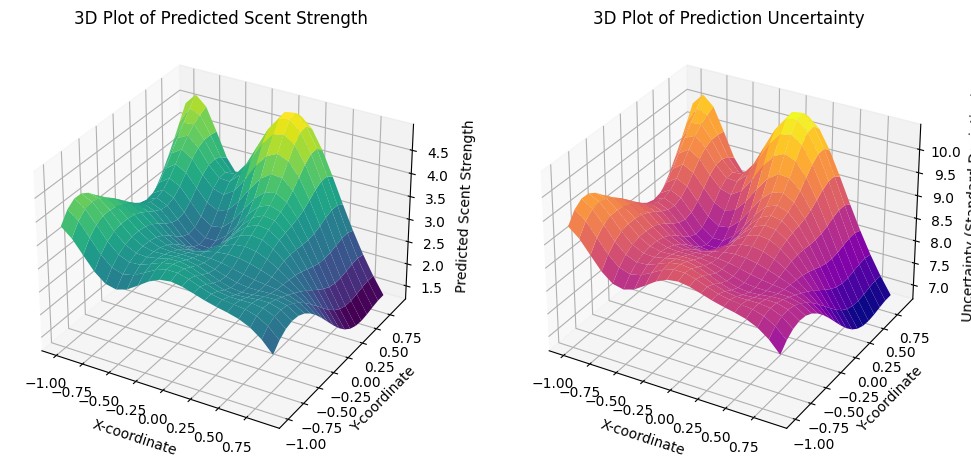

In [70]:
# Reshape y_pred and sigma to match the grid shape
mu_grid = mu.reshape(len(x), len(y))
sigma_grid = sigma.reshape(len(x), len(y))
ei_grid = (ei+10).reshape(len(x), len(y))

# Create figure with two 3D subplots
fig = plt.figure(figsize=(12, 6))

# 1st subplot: Predicted Scent Strength
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, mu_grid, cmap='viridis', edgecolor='none')
ax1.set_xlabel('X-coordinate')
ax1.set_ylabel('Y-coordinate')
ax1.set_zlabel('Predicted Scent Strength')
ax1.set_title('3D Plot of Predicted Scent Strength')

# 2nd subplot: Uncertainty (Standard Deviation)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, ei_grid, cmap='plasma', edgecolor='none')
ax2.set_xlabel('X-coordinate')
ax2.set_ylabel('Y-coordinate')
ax2.set_zlabel('Uncertainty (Standard Deviation)')
ax2.set_title('3D Plot of Prediction Uncertainty')

# Show the plots
plt.show()